<center>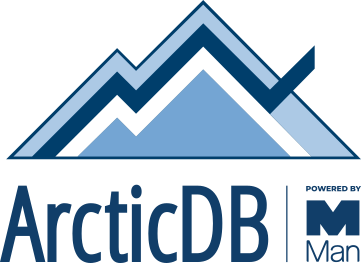
</center>

# Loading Bitcoin data with ArcticDB

### Install ArcticDB and S3 libraries

In [ ]:
%pip install arcticdb boto3 tqdm s3fs
# s3fs is used by pandas.read_parquet('s3://...')

### Imports

In [5]:
import os, getpass
from uuid import uuid4
from datetime import timedelta
from tqdm import tqdm
import boto3
import pandas as pd
from botocore import UNSIGNED
from botocore.client import Config
from arcticdb import Arctic, QueryBuilder, LibraryOptions

### Makes sure some AWS config exists

In [6]:
check = boto3.session.Session()

if check.get_credentials() is None or check.region_name is None:
    print('*'*40)
    print('Setup your AWS S3 credentials and region before continuing.')
    print('https://boto3.amazonaws.com/v1/documentation/api/latest/guide/credentials.html')
    print('*'*40)

### Find bucket or initialise a new one

In [7]:
s3 = boto3.resource('s3')
region = boto3.session.Session().region_name

bucket = [b for b in s3.buckets.all() if b.name.startswith('arcticdb-data-')]

if bucket:
  bucket_name = bucket[0].name
  print('Bucket found:', bucket_name)
else:
  bucket_name = f'arcticdb-data-{uuid4()}'
  s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint':region})
  print('Bucket created:', bucket_name)

Bucket created: arcticdb-data-3355f445-e4b5-4e3b-84ba-b3e237f270ec


### Initialise ArcticDB

In [8]:
# create an arcticdb instance in that bucket
arctic = Arctic(f's3://s3.{region}.amazonaws.com:{bucket_name}?aws_auth=true')

if 'btc' not in arctic.list_libraries():
    # library does not already exist
    arctic.create_library('btc', library_options=LibraryOptions(dynamic_schema=True))
library = arctic.get_library('btc')
library

Library(Arctic(config=S3(endpoint=s3.eu-west-2.amazonaws.com, bucket=arcticdb-data-3355f445-e4b5-4e3b-84ba-b3e237f270ec)), path=btc, storage=s3_storage)

### Find out what data needs importing

In [9]:
bucket = s3.Bucket('aws-public-blockchain')
objects = bucket.objects.filter(Prefix='v1.0/btc/transactions/')
files = pd.DataFrame({'path': [obj.key for obj in objects]})

files['date'] = files['path'].str.extract(r'(\d{4}-\d{2}-\d{2})')
files['date'] = pd.to_datetime(files['date']).dt.date

if library.has_symbol('transactions'):
    # load everything after the last date in ArcticDB
    start = library.get_description('transactions').date_range[1].date()
else:
    print('First time')
    start = files['date'].min() - timedelta(days=1)

to_load = files[files['date']>start]['path']
print(f'Need to import {len(to_load)} files after {start}.')

First time
Need to import 5455 files after 2009-01-02.


### Import the data into ArcticDB

In [ ]:
for path in tqdm(to_load):
    df = pd.read_parquet('s3://aws-public-blockchain/'+path, storage_options={"anon": True})
    # fixup types from source data
    df['hash'] =  df['hash'].astype(str)
    df['block_hash'] = df['block_hash'].astype(str)
    df['outputs'] = df['outputs'].astype(str)
    df['date'] = pd.to_datetime(df['date'], unit='ns')
    if 'inputs' in df.columns:
      df['inputs'] = df['inputs'].astype(str)
    # index on timestamp
    df.set_index('block_timestamp', inplace=True)
    df.sort_index(inplace=True)
    # write the data
    library.append('transactions', df)
    if library.is_symbol_fragmented('transactions'):
      print('compaction')
      library.defragment_symbol_data('transactions')


  0%|                                                                                                                                                                                                                  | 0/5455 [00:00<?, ?it/s]/home/james/miniforge3/envs/ArcticDB/lib/python3.11/site-packages/fsspec/registry.py:271: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)
  2%|███▋                                                                                                                                                                                                  | 101/5455 [02:43<4:57:44,  3.34s/it]

defrag


  4%|███████▎                                                                                                                                                                                              | 201/5455 [05:17<5:49:30,  3.99s/it][2023-09-10 16:45:44.271] [arcticdb] [info] Defragmenting data for symbol transactions


defrag


  6%|██████████▉                                                                                                                                                                                           | 301/5455 [07:53<6:52:11,  4.80s/it][2023-09-10 16:48:17.109] [arcticdb] [info] Defragmenting data for symbol transactions


defrag


  7%|██████████████▌                                                                                                                                                                                       | 401/5455 [10:34<8:17:53,  5.91s/it]

defrag


  9%|██████████████████                                                                                                                                                                                   | 501/5455 [13:39<11:38:13,  8.46s/it]

defrag


 11%|█████████████████████▋                                                                                                                                                                               | 602/5455 [17:48<23:18:12, 17.29s/it]

defrag


 13%|█████████████████████████▍                                                                                                                                                                           | 703/5455 [22:37<23:39:32, 17.92s/it][2023-09-10 17:02:19.535] [arcticdb] [info] Defragmenting data for symbol transactions


defrag


 15%|█████████████████████████████                                                                                                                                                                        | 804/5455 [30:04<55:29:09, 42.95s/it]

defrag


 17%|████████████████████████████████▊                                                                                                                                                                    | 909/5455 [47:21<18:33:06, 14.69s/it]